<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Superman_Tracker_YoloV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Step 0: Essentials

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

##Download Some Video Clips of Superman from this [Source](https://lyricslive24.com/superman-action-scene/)

In [ ]:
#Sample Videos
!wget https://lived2.lyricslive24.com/mp4regular/play/eDdtQk1BNzNoRlgxcjk4dFdzUTEwUT09/Superman-vs-Wonder-women-fight-scene-WhatsApp-status---justice-league--Superman.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/VVZjNlFoZEJOaHk2Y0U5cUFjNWVmUT09/SuperMan-Returns---WhatsApp-Status--Fight-Scene-.mp4
!wget https://vfss.b-cdn.net/library/S/Superman-Status-Video/Superman-attitude-full-screen-Shorts.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/T0dLK3ZOTXllVW5IMVJqMUtNZzNXZz09/Whatsapp-Superman-Status-Scene-Fight.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/S0J1WVVIV3A3R1ZJN3hZeDRMb3dNZz09/superman-amazing-fighting-scene-whatsApp-status-short.mp4
!wget https://lived2.lyricslive24.com/mp4regular/play/SXpXaGFxZy8wTlVxS3lGRUNvZldZUT09/Superman-Superman-whatsapp-Trinity-wonder-Batman-status-Batman-woman-scene-from-v.mp4

#Step 1: Darknet
To use yolo v4 model, you can get it easily from darknet or you can create a yolo v4 model from scratch

In [5]:
#clone Darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15494, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15494 (delta 0), reused 2 (delta 0), pack-reused 15490
Receiving objects: 100% (15494/15494), 14.11 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (10408/10408), done.


In [6]:
# change makefile to have gpu and opencv enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
#Build(make) Darknet
!make

#Step 2: Dataset
you can get The Dataset From [Kaggle](https://www.kaggle.com/datasets/mralamdari/superman-or-batman)

In [ ]:
%cd /content/
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/'
!kaggle datasets download -d mralamdari/super-man-images-dataset
!unzip \*.zip && rm *.zip

1. Create obj.names
2. Move images to /content/darknet/
3. Create train.txt in /content/darknet/data/obj folder

In [13]:
NUM_CLASSES = 1
picture_folder='SuperMan'

os.rename(f'/content/{picture_folder}/classes.txt', '/content/darknet/data/obj.names')

os.rename(f'/content/{picture_folder}', '/content/darknet/data/obj/')

data_path='/content/darknet/data/'
with open(f'{data_path}train.txt', 'w+') as data_file:
      for image_file in os.listdir(f'{data_path}obj'):
          if image_file.endswith('.jpg'):
              data_file.write(f'{os.path.join(f"{data_path}obj", image_file)}\n')
data_file.close()    

Adjust yolov4-custom to trainning


In [10]:
with open('/content/darknet/cfg/yolov4.cfg', 'r+') as f:
    config_files = f.readlines()

config_files[1] = 'batch=64\n'
config_files[2] = 'subdivisions=64\n'


max_batches = 4000 if NUM_CLASSES==1 else NUM_CLASSES*2000
config_files[18] = f'max_batches={max_batches}\n'
config_files[20] = f'steps={max_batches*8//10},{max_batches*9//10}\n'


for i, line in enumerate(config_files):
    if line == '[yolo]\n':
        config_files[i-4] = f"filters={3*(5+NUM_CLASSES)}\n" # convolutional filters
        config_files[i+3] = f"classes={NUM_CLASSES}\n"       # yolo_classes


with open('/content/darknet/cfg/yolov4-custom.cfg', 'w+') as f:
    f.writelines(config_files)

Create Obj.data

In [11]:
with open('/content/darknet/data/obj.data', 'w+') as obj_data:
  odata = f"""classes={NUM_CLASSES}
  train=/content/darknet/data/train.txt
  valid=/content/darknet/data/test.txt
  names=/content/darknet/data/obj.names
  backup=/content/drive/MyDrive/Superman_Tracker_YoloV4_backup
  """
  obj_data.write(odata)

# os.makedirs('/content/drive/MyDrive/Superman_Tracker_YoloV4_backup', exist_ok=True)

#Step 3: Model

Get pre-trained weights for yolo

In [ ]:
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

### Train from scratch

#####Use this code, so colab won't crash after being inactive for more than 10 mins;

    function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
    }
    setInterval(ClickConnect,60000)

In [ ]:
!./darknet detector train /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/darknet/yolov4.conv.137 -dont_show

In [ ]:
imShow('chart.png')

### Train from where you ceased training with saved weights.

In [ ]:
%cd /content/darknet
!./darknet detector train /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights -dont_show

In [ ]:
imShow('chart.png')

Adjust yolov4-custom.cfg for testing


In [14]:
with open('/content/darknet/cfg/yolov4-custom.cfg', 'r+') as f:
    config_files = f.readlines()

config_files[1] = 'batch=1\n'
config_files[2] = 'subdivisions=1\n'

with open('/content/darknet/cfg/yolov4-custom.cfg', 'w+') as f:
    f.writelines(config_files)

##Predict 

###Image Prediction

In [23]:
%cd /content/darknet
!./darknet detector test /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/darknet/data/obj/158.jpg -thresh 0.4 -dont_show

/content/darknet
 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1

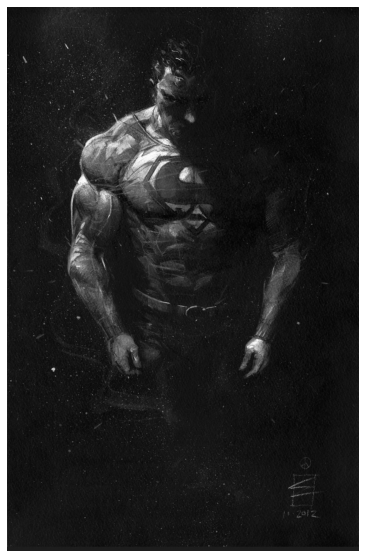

In [24]:
imShow('predictions.jpg')

###Video Prediction

In [ ]:
%cd /content/darknet
output_video = '/content/results.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/6.mp4 -dont_show -i 0 -out_filename $output_video

# ddddd

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_1.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/1.mp4 -dont_show -i 0 -out_filename $output_video

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_2.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/2.mp4 -dont_show -i 0 -out_filename $output_video

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_3.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/3.mp4 -dont_show -i 0 -out_filename $output_video

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_4.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/4.mp4 -dont_show -i 0 -out_filename $output_video

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_5.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/5.mp4 -dont_show -i 0 -out_filename $output_video

In [ ]:

%cd /content/darknet
output_video = '/content/drive/MyDrive/results_6.avi'

!./darknet detector demo /content/darknet/data/obj.data /content/darknet/cfg/yolov4-custom.cfg /content/drive/MyDrive/Superman_Tracker_YoloV4_backup/yolov4-custom_last.weights /content/6.mp4 -dont_show -i 0 -out_filename $output_video